# Setup

In [0]:
# Setup - import common modules
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Are we running on local or colab?
if 'edwardrees' in sys.exec_prefix:
    device_loc = 'local'
else:
    device_loc = 'colab'

# Add local drive to path if running on colab
if device_loc == 'local':
    dir_ = '.'
elif device_loc == 'colab':
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    dir_ = 'drive/My Drive/GA/Capstone'
    if dir_ not in sys.path:
        sys.path.append(dir_)

# Check if using gpu if on colab
if device_loc == 'colab':
    %tensorflow_version 2.x
    import tensorflow as tf
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))
elif device_loc == 'local':
    import tensorflow as tf

# Import split folders
!pip install split_folders
import split_folders

Mounted at /content/drive
Found GPU at: /device:GPU:0


# Set up dataset and train/test split

In [0]:
# Which problem are we looking at?
problem = 'all'

# Download the fake vs real dataset from github
database_repo = './ml-database/real_and_fake_face'

if device_loc =='colab' and not os.path.exists(database_repo):
    !git clone https://github.com/Rees451/ml-database

# Setup the problem as a ovr problem by running the ovr_file_sorter.py script 
!python '{dir_}/ovr_file_sorter.py'

Copied 2041 images successfully


In [0]:
if problem == 'all':
    origin_path = f'./ml-database/real_and_fake_face'
else:
    origin_path = f'./data/real_and_fake_face_ovr_links/{problem}'

problem_path = f'./data/sf/{problem}'

!rm -rf $problem_path
#split_folders.fixed(f'./data/real_and_fake_face_ovr_links/{problem}', 
#                    problem_path, 
#                    fixed=(500, 150), 
#                    oversample=True)

split_folders.ratio(origin_path, 
                    problem_path,)

# Train, test, val paths
train_dir = problem_path+'/train'
test_dir = problem_path+'/test'
val_dir = problem_path+'/val'


Copying files: 0 files [00:00, ? files/s]
Copying files: 275 files [00:00, 2746.39 files/s]
Copying files: 611 files [00:00, 2905.05 files/s]
Copying files: 930 files [00:00, 2981.52 files/s]
Copying files: 1137 files [00:00, 2209.28 files/s]
Copying files: 1366 files [00:00, 2232.00 files/s]
Copying files: 1598 files [00:00, 2255.47 files/s]
Copying files: 1807 files [00:00, 2171.82 files/s]
Copying files: 2041 files [00:00, 2391.86 files/s]

# Functions

In [0]:
def baseline(dataset_path):
    n_real = len([i for i in os.listdir(dataset_path+'/real') if '.jpg' in i])
    n_fake = len([i for i in os.listdir(dataset_path+'/fake') if '.jpg' in i])
    print('\n', dataset_path)
    print(n_real, 'real images')
    print(n_fake, 'fake images')
    print(n_real + n_fake, 'images')
    print('Baseline of {0:.5f}'.format(max(n_real, n_fake)/(n_real+n_fake)))

In [0]:
def plot_training(history):
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epoch = range(1, len(train_accuracy)+1)
    fig, ax = plt.subplots()
    ax.plot(epoch, train_accuracy, label = 'Training Accuracy')
    ax.plot(epoch, val_accuracy, label = 'Validation Accuracy')
    ax.legend()

# Datagen

In [0]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                rotation_range=0.1, 
                                                                height_shift_range=0.1,
                                                                horizontal_flip=True)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

target_size = (224, 224)
# Trainining dataset generator
train = train_datagen.flow_from_directory(train_dir,
                                          class_mode="binary",
                                          target_size=target_size,
                                          batch_size=32)

# Validation dataset generator
val = test_datagen.flow_from_directory(val_dir,
                                       class_mode="binary",
                                       target_size=target_size,
                                       batch_size=32)

# Test dataset generator
test = test_datagen.flow_from_directory(test_dir,
                                        class_mode="binary",
                                        target_size=target_size,
                                        batch_size=1)

Found 1632 images belonging to 2 classes.
Found 204 images belonging to 2 classes.
Found 205 images belonging to 2 classes.


In [0]:
baseline(train_dir)
baseline(val_dir)
baseline(test_dir)


 ./data/sf/all/train
864 real images
768 fake images
1632 images
Baseline of 0.52941

 ./data/sf/all/val
108 real images
96 fake images
204 images
Baseline of 0.52941

 ./data/sf/all/test
109 real images
96 fake images
205 images
Baseline of 0.53171


# Model 1

In [0]:
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(224, 224, 3),
                          include_top=False,
                          weights='imagenet'
                          )

In [0]:
#for layer in base_model.layers:
    #layer.trainable = False

In [0]:
average_layer = tf.keras.layers.GlobalAveragePooling2D()

model = tf.keras.Sequential([
    base_model,
    average_layer,
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

Look at l2 regulirsation for dense layers
The weight intilisations
Classify each part on its own
different ways of pooling, strides, 
Have a look at different optimizers, e.g. rsprop

Look at early stopping as well

In [0]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_41 (Dense)             (None, 256)               327936    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_58 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 257       
Total params: 2,587,201
Trainable params: 2,552,577
Non-trainable params: 34,624
______________________________________

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
def scheduler(epoch):
    if epoch <= 2:
        return 0.001
    elif epoch > 2 and epoch <= 15:
        return 0.0001 
    else:
        return 0.00001

lr_callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [0]:
def learning_scheduler(epoch):
    if epoch <=2:
        learning = false

In [0]:
model.fit_generator(train,
                    epochs=10,
                    callbacks=[lr_callbacks], validation_data = val)

model.evaluate_generator(test)

Epoch 1/10
51/51 [==============================] - 53s 1s/step - loss: 0.5786 - accuracy: 0.7108 - val_loss: 1.4283 - val_accuracy: 0.5588
Epoch 2/10
51/51 [==============================] - 47s 927ms/step - loss: 0.5195 - accuracy: 0.7598 - val_loss: 0.8126 - val_accuracy: 0.6275
Epoch 3/10
51/51 [==============================] - 47s 929ms/step - loss: 0.4378 - accuracy: 0.8045 - val_loss: 1.3812 - val_accuracy: 0.5343
Epoch 4/10
51/51 [==============================] - 47s 928ms/step - loss: 0.3262 - accuracy: 0.8572 - val_loss: 1.5861 - val_accuracy: 0.6029
Epoch 5/10
51/51 [==============================] - 49s 951ms/step - loss: 0.2344 - accuracy: 0.8989 - val_loss: 1.6640 - val_accuracy: 0.5539
Epoch 6/10
51/51 [==============================] - 48s 938ms/step - loss: 0.2150 - accuracy: 0.9112 - val_loss: 1.2308 - val_accuracy: 0.5931
Epoch 7/10
51/51 [==============================] - 48s 945ms/step - loss: 0.1844 - accuracy: 0.9197 - val_loss: 1.1509 - val_accuracy: 0.6029
Ep

[1.6925784846463126, 0.58536583]

In [0]:
model.evaluate_generator(test)

[1.6925784846463126, 0.58536583]

# Model 2

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, 3, strides = (2,2), activation="relu", padding="same",
                        input_shape=[224, 224, 3]),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

In [0]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 112, 112, 64)      1792      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 28, 28, 256)       295168    
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 14, 14, 256)       0         
_________________________________________________________________
global_average_pooling2d_5 ( (None, 256)             

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model.fit_generator(train,
                    epochs=10)

Epoch 1/10
52/52 [==============================] - 37s 719ms/step - loss: 0.7679 - accuracy: 0.5034
Epoch 2/10
52/52 [==============================] - 37s 708ms/step - loss: 0.7036 - accuracy: 0.5389
Epoch 3/10
52/52 [==============================] - 37s 705ms/step - loss: 0.6985 - accuracy: 0.5187
Epoch 4/10
52/52 [==============================] - 36s 698ms/step - loss: 0.6917 - accuracy: 0.5328
Epoch 5/10
52/52 [==============================] - 36s 697ms/step - loss: 0.6924 - accuracy: 0.5260
Epoch 6/10
52/52 [==============================] - 36s 691ms/step - loss: 0.6913 - accuracy: 0.5266
Epoch 7/10
52/52 [==============================] - 36s 691ms/step - loss: 0.6936 - accuracy: 0.5321
Epoch 8/10
52/52 [==============================] - 36s 694ms/step - loss: 0.6967 - accuracy: 0.5389
Epoch 9/10
52/52 [==============================] - 36s 693ms/step - loss: 0.6922 - accuracy: 0.5309
Epoch 10/10
52/52 [==============================] - 36s 698ms/step - loss: 0.6913 - accura

In [0]:
model.evaluate_generator(test)

[0.6922218386943524, 0.53071254]

# Model 3 - VGG Model

In [0]:
os.path.exists('drive/My Drive/GA/Capstone/vgg.py')

True

In [0]:
%run 'drive/My Drive/GA/Capstone/vgg.py'

Using TensorFlow backend.


FileNotFoundError: ignored

# Model 4 - Mobile Net V2 Base

In [0]:
# Initalize the MobileNetV2 model that will for the base for our classifier
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(224, 224, 3),
                          include_top=False,
                          weights='imagenet'
                          )

In [0]:
k = -11
for layer in base_model.layers[:k]:
    layer.trainable = False

average_layer = tf.keras.layers.GlobalAveragePooling2D()

reg = tf.keras.regularizers.l2(l=0.05)

model = tf.keras.Sequential([
    base_model,
    average_layer,
    tf.keras.layers.Dense(64, activation=tf.nn.relu, kernel_regularizer=reg, bias_regularizer=reg),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation=tf.nn.relu, kernel_regularizer=reg, bias_regularizer=reg),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

	
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

model.compile(optimizer=tf.keras.optimizers.RMSprop(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              callbacks=[es, lr_scheduler])

history = model.fit_generator(train,
                    epochs=10, validation_data = val)

model.evaluate_generator(test)

Epoch 1/10
51/51 [==============================] - 40s 781ms/step - loss: 8.8598 - accuracy: 0.8143 - val_loss: 8.5068 - val_accuracy: 0.6553
Epoch 2/10
51/51 [==============================] - 31s 607ms/step - loss: 7.5427 - accuracy: 0.9062 - val_loss: 7.4183 - val_accuracy: 0.5874
Epoch 3/10
51/51 [==============================] - 30s 590ms/step - loss: 6.4287 - accuracy: 0.9400 - val_loss: 6.4569 - val_accuracy: 0.4806
Epoch 4/10
51/51 [==============================] - 30s 584ms/step - loss: 5.4543 - accuracy: 0.9638 - val_loss: 5.6249 - val_accuracy: 0.3883
Epoch 5/10
51/51 [==============================] - 31s 600ms/step - loss: 4.6186 - accuracy: 0.9761 - val_loss: 4.8842 - val_accuracy: 0.3786
Epoch 6/10
51/51 [==============================] - 30s 589ms/step - loss: 3.9004 - accuracy: 0.9792 - val_loss: 4.2768 - val_accuracy: 0.4175
Epoch 7/10
51/51 [==============================] - 29s 564ms/step - loss: 3.2875 - accuracy: 0.9847 - val_loss: 3.8101 - val_accuracy: 0.4029

[2.7330053193228587, 0.39408866]

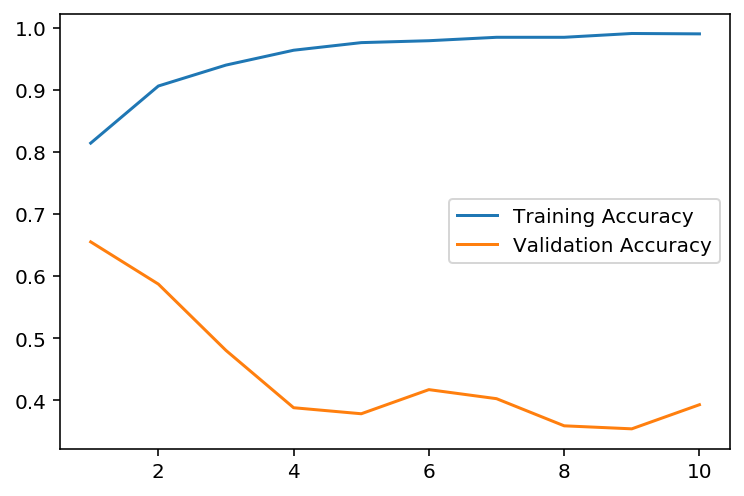

In [0]:
plot_training(history)

In [0]:
model.evaluate_generator(test)

[2.7570443153381348, 0.39408866]

In [0]:
baseline(test_data)

137 real images
69 fake images
206 images
Baseline of 0.6650485436893204


In [0]:
predictions = model.predict_classes()

In [0]:
tf.math.confusion_matrix(test.classes, predictions)

InvalidArgumentError: ignored

In [0]:
train.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

# Model 5 - Mobile Net V2 Base


In [0]:
def scheduler(epoch):
    if epoch <= 2:
        return 0.001
    elif epoch > 2 and epoch <= 15:
        return 0.0001 
    else:
        return 0.00001

lr_callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [0]:
k = -22
for layer in base_model.layers[:k]:
    layer.trainable = False

average_layer = tf.keras.layers.GlobalAveragePooling2D()

reg = tf.keras.regularizers.l1(l=0.05)

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu, kernel_regularizer=reg, bias_regularizer=reg),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation=tf.nn.relu, kernel_regularizer=reg, bias_regularizer=reg),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

	
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

model.compile(optimizer=tf.keras.optimizers.RMSprop(),
              loss='binary_crossentropy',
              metrics=['accuracy'],
              callbacks=[es, lr_callbacks])

history = model.fit_generator(train,
                              epochs=10, 
                              validation_data = val)

model.evaluate_generator(test)

Epoch 1/10
51/51 [==============================] - 67s 1s/step - loss: 124.9683 - accuracy: 0.5888 - val_loss: 25.5112 - val_accuracy: 0.6700
Epoch 2/10
51/51 [==============================] - 68s 1s/step - loss: 19.0385 - accuracy: 0.6275 - val_loss: 13.7149 - val_accuracy: 0.6700
Epoch 3/10
51/51 [==============================] - 64s 1s/step - loss: 10.4920 - accuracy: 0.6661 - val_loss: 8.2205 - val_accuracy: 0.6700
Epoch 4/10
51/51 [==============================] - 62s 1s/step - loss: 7.7412 - accuracy: 0.6685 - val_loss: 7.6310 - val_accuracy: 0.6700
Epoch 5/10
51/51 [==============================] - 63s 1s/step - loss: 7.6150 - accuracy: 0.6685 - val_loss: 7.5969 - val_accuracy: 0.6700
Epoch 6/10
51/51 [==============================] - 63s 1s/step - loss: 7.6087 - accuracy: 0.6685 - val_loss: 7.6151 - val_accuracy: 0.6700
Epoch 7/10
51/51 [==============================] - 63s 1s/step - loss: 7.6041 - accuracy: 0.6685 - val_loss: 7.5901 - val_accuracy: 0.6700
Epoch 8/10
51/

[7.599718459601541, 0.66504854]

# Model 6 - VGG16

In [0]:
base_model = tf.keras.applications.vgg16.VGG16(include_top=False, 
                                            weights='imagenet', 
                                            input_tensor=None, 
                                            input_shape=(224,224,3), 
                                            pooling=None, 
                                            classes=2)

58892288/58889256 [==============================] - 2s 0us/step


In [0]:
k = -22
for layer in base_model.layers[:k]:
    layer.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu, kernel_regularizer=reg, bias_regularizer=reg),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation=tf.nn.relu, kernel_regularizer=reg, bias_regularizer=reg),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

	
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

model.compile(optimizer=tf.keras.optimizers.RMSprop(),
              loss='binarycrossentropy',
              metrics=['accuracy'],
              callbacks=[es, lr_callbacks])

history = model.fit_generator(train,
                              epochs=10, 
                              validation_data = val)

model.evaluate_generator(test)

Epoch 1/10
51/51 [==============================] - 64s 1s/step - loss: 179.4607 - accuracy: 0.4632 - val_loss: 110.4980 - val_accuracy: 0.3744
Epoch 2/10
51/51 [==============================] - 63s 1s/step - loss: 96.1267 - accuracy: 0.4400 - val_loss: 74.6157 - val_accuracy: 0.3300
Epoch 3/10
51/51 [==============================] - 63s 1s/step - loss: 60.8790 - accuracy: 0.4706 - val_loss: 69.4792 - val_accuracy: 0.6700
Epoch 4/10
51/51 [==============================] - 63s 1s/step - loss: 64.9273 - accuracy: 0.6661 - val_loss: 59.1607 - val_accuracy: 0.6700
Epoch 5/10
51/51 [==============================] - 63s 1s/step - loss: 58.0039 - accuracy: 0.6661 - val_loss: 56.4653 - val_accuracy: 0.6700
Epoch 6/10
21/51 [===========>..................] - ETA: 33s - loss: 53.8796 - accuracy: 0.6473

KeyboardInterrupt: ignored

# Model 7 - VGG faces

In [0]:
vgg_face_weights = f'{dir_}/models/resnet50_softmax_dim512/weights.h5'

In [0]:
vgg_face_model = tf.keras.models.load_model(vgg_face_weights)

In [0]:
layers_to_remove = 3
base_model = tf.keras.Model(vgg_face_model.input, vgg_face_model.layers[-(layers_to_remove+1)].output)

In [0]:
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
base_input (InputLayer)         [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        base_input[0][0]                 
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
______________________________________________________________________________________________

In [0]:
trainable = [(layer, layer.trainable) for layer in base_model.layers]

In [0]:
def scheduler(epoch):
    if epoch <= 3:
        return 0.008
    elif epoch > 3 and epoch <= 15:
        return 0.004000 
    else:
        return 0.0025

lr_callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [0]:
# Top number layers to train
k = 12
# Number of layers
n = len(base_model.layers)

for layer in base_model.layers[:(n-k)]:
    layer.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2048, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

	
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'],
              callbacks=[es, lr_callbacks])

history = model.fit_generator(train,
                              epochs=10, 
                              validation_data = val)

model.evaluate_generator(test)

Epoch 1/10
51/51 [==============================] - 60s 1s/step - loss: 8.2532 - accuracy: 0.4688 - val_loss: 8.4317 - val_accuracy: 0.4706
Epoch 2/10
48/51 [===========================>..] - ETA: 2s - loss: 8.4043 - accuracy: 0.4674

KeyboardInterrupt: ignored

In [0]:
conf_matrix(model, test)

,Predicted Fake,Predicted Real
Actual Fake,69,0
Actual Real,137,0


In [0]:
conf_matrix(model, train)

,Predicted Fake,Predicted Real
Actual Fake,541,0
Actual Real,1091,0


In [0]:
def conf_matrix(model, data_gen):
            predict_labels = prob_to_labels(model.predict(data_gen))
            return pd.DataFrame(confusion_matrix(data_gen.classes, predict_labels),
                                columns=['Predicted Fake', ' Predicted Real'], 
                                index = ['Actual Fake', 'Actual Real'])

In [0]:
model.evaluate_generator(train)

[1.0427528269150679, 0.3314951]

# Model 8

In [0]:
optimizer = tf.keras.optimizers.RMSprop()
loss = 'binary_crossentropy'
dropout = 0.1


classifier = tf.keras.Sequential() # Initialising the CNN    
classifier.add(tf.keras.layers.Conv2D(32, (3, 3), input_shape = (600, 600, 3), activation = 'relu')) 
classifier.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2))) 
classifier.add(tf.keras.layers.Dropout(dropout))
classifier.add(tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'))  
classifier.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))
classifier.add(tf.keras.layers.Dropout(dropout))
classifier.add(tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'))  
classifier.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))
classifier.add(tf.keras.layers.Dropout(dropout))
classifier.add(tf.keras.layers.Flatten())
classifier.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
classifier.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid')) #'tanh'))

classifier.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

In [0]:
history = classifier.fit_generator(train, epochs=10, validation_data=val)

Epoch 1/10
51/51 [==============================] - 164s 3s/step - loss: 1.2531 - accuracy: 0.5067 - val_loss: 0.6933 - val_accuracy: 0.5294
Epoch 2/10
51/51 [==============================] - 160s 3s/step - loss: 0.7282 - accuracy: 0.5043 - val_loss: 0.6924 - val_accuracy: 0.5294
Epoch 3/10
51/51 [==============================] - 160s 3s/step - loss: 0.7041 - accuracy: 0.5110 - val_loss: 0.6946 - val_accuracy: 0.5441
Epoch 4/10
51/51 [==============================] - 159s 3s/step - loss: 0.7160 - accuracy: 0.5276 - val_loss: 0.6932 - val_accuracy: 0.5686
Epoch 5/10
51/51 [==============================] - 159s 3s/step - loss: 0.7579 - accuracy: 0.5637 - val_loss: 0.6881 - val_accuracy: 0.5294
Epoch 6/10
 5/51 [=>............................] - ETA: 1:54 - loss: 0.6607 - accuracy: 0.5813

KeyboardInterrupt: ignored

In [0]:
classifier.evaluate_generator(test)

[0.6645675245218161, 0.61463416]

In [0]:
classifier.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 52, 52, 32)       

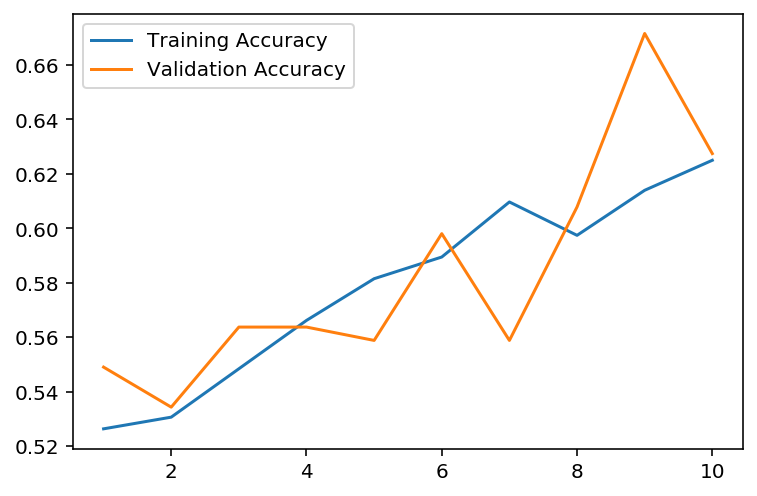

In [0]:
plot_training(history)

In [0]:
baseline(test_dir)


 ./data/sf/all/test
109 real images
96 fake images
205 images
Baseline of 0.53171


In [0]:
conf_matrix(classifier, train)

,Predicted Fake,Predicted Real
Actual Fake,446,322
Actual Real,469,395


In [0]:
def prob_to_labels(predict_prob):
        if len(predict_prob[0]) == 1:
            predict_labels = [1 if i > 0.5 else 0 for i in predict_prob]  
        else:
            pass
        return predict_labels

# Model 9

In [0]:
optimizer = tf.keras.optimizers.RMSprop()
loss = 'binary_crossentropy'
dropout = 0.1


classifier = tf.keras.Sequential() # Initialising the CNN
   
classifier.add(tf.keras.layers.Conv2D(32, (3, 3), input_shape = (300, 300, 3), dilation_rate = (2,2), activation = 'relu')) 
classifier.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2))) 
classifier.add(tf.keras.layers.Dropout(dropout))
classifier.add(tf.keras.layers.Conv2D(32, (3, 3), dilation_rate = (2,2), activation = 'relu'))  
classifier.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))
classifier.add(tf.keras.layers.Dropout(dropout)) 
classifier.add(tf.keras.layers.Conv2D(32, (3, 3), dilation_rate = (2,2), activation = 'relu'))  
classifier.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))
classifier.add(tf.keras.layers.Dropout(dropout))
classifier.add(tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'))  
classifier.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))
classifier.add(tf.keras.layers.Dropout(dropout))
classifier.add(tf.keras.layers.Flatten())
classifier.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
classifier.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid')) #'tanh'))

classifier.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

history = classifier.fit_generator(train, epochs = 10, validation_data = val)

plot_training(history)

In [0]:
history = classifier.fit_generator(train, epochs = 10, validation_data = val)

Epoch 1/10
51/51 [==============================] - 65s 1s/step - loss: 6.9675 - accuracy: 0.4798 - val_loss: 0.6919 - val_accuracy: 0.5294
Epoch 2/10
51/51 [==============================] - 54s 1s/step - loss: 0.7050 - accuracy: 0.5270 - val_loss: 0.6919 - val_accuracy: 0.5343
Epoch 3/10
51/51 [==============================] - 55s 1s/step - loss: 0.7172 - accuracy: 0.5423 - val_loss: 0.6888 - val_accuracy: 0.5637
Epoch 4/10
51/51 [==============================] - 54s 1s/step - loss: 0.6891 - accuracy: 0.5588 - val_loss: 0.6785 - val_accuracy: 0.6029
Epoch 5/10
51/51 [==============================] - 54s 1s/step - loss: 0.6968 - accuracy: 0.5588 - val_loss: 0.6905 - val_accuracy: 0.5294
Epoch 6/10
51/51 [==============================] - 54s 1s/step - loss: 0.6898 - accuracy: 0.5674 - val_loss: 0.6746 - val_accuracy: 0.5637
Epoch 7/10
51/51 [==============================] - 53s 1s/step - loss: 0.6810 - accuracy: 0.5625 - val_loss: 0.6754 - val_accuracy: 0.6324
Epoch 8/10
51/51 [==

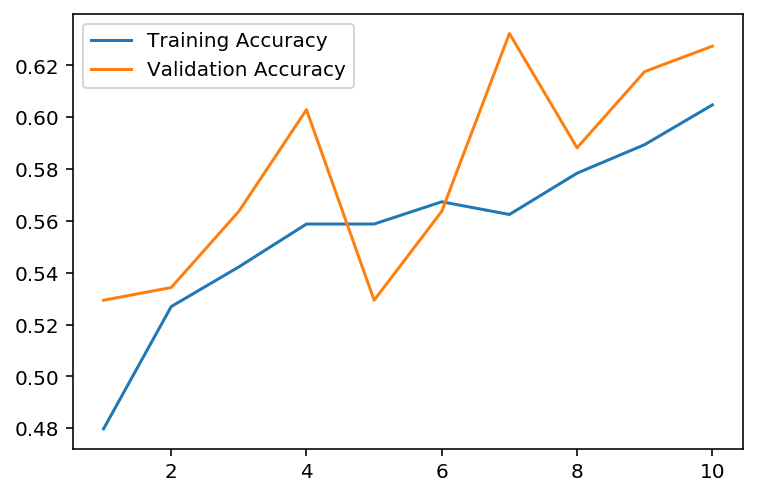

In [0]:
plot_training(history)

In [0]:
optimizer = tf.keras.optimizers.RMSprop()
loss = 'binary_crossentropy'
dropout = 0.1


classifier = tf.keras.Sequential() # Initialising the CNN
   
classifier.add(tf.keras.layers.Conv2D(32, (3, 3), input_shape = (300, 300, 3), dilation_rate = (2,2), activation = 'relu')) 
classifier.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2))) 
classifier.add(tf.keras.layers.Dropout(dropout))
classifier.add(tf.keras.layers.Conv2D(32, (3, 3), dilation_rate = (2,2), activation = 'relu'))  
classifier.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))
classifier.add(tf.keras.layers.Dropout(dropout)) 
classifier.add(tf.keras.layers.Conv2D(32, (3, 3), dilation_rate = (2,2), activation = 'relu'))  
classifier.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))
classifier.add(tf.keras.layers.Dropout(dropout))
classifier.add(tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'))  
classifier.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))
classifier.add(tf.keras.layers.Dropout(dropout))
classifier.add(tf.keras.layers.Flatten())
classifier.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
classifier.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid')) #'tanh'))

classifier.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

history = classifier.fit_generator(train, epochs = 15, validation_data = val)

plot_training(history)

Epoch 1/15
19/51 [==========>...................] - ETA: 41s - loss: 1.4523 - accuracy: 0.4967

KeyboardInterrupt: ignored